In [1]:
%config Completer.use_jedi = False

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

In [4]:
df = pd.read_csv(
    '../resources/book_sales.csv',
    parse_dates = ['Date'],
    index_col='Date'
).drop('Paperback', axis=1)


In [5]:
df['Time'] = np.arange(len(df.index))

In [6]:
df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


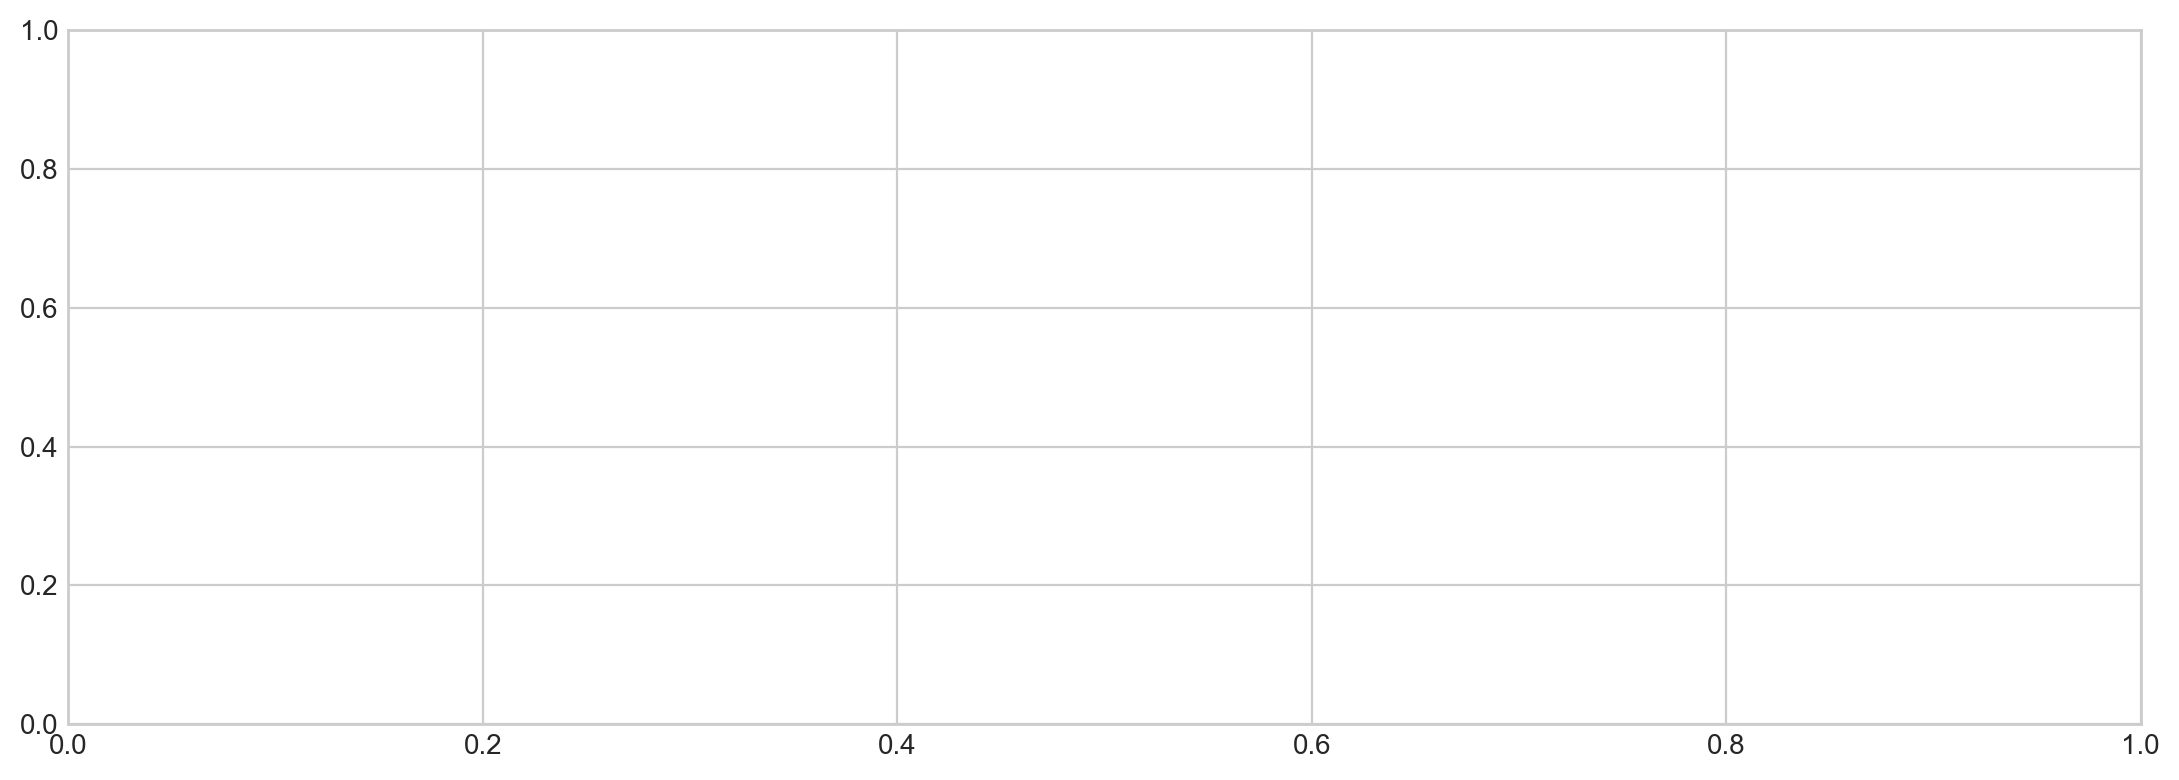

In [7]:
fig, ax = plt.subplots()

In [8]:
ax.plot('Time', 'Hardcover', data=df, color='0.90')

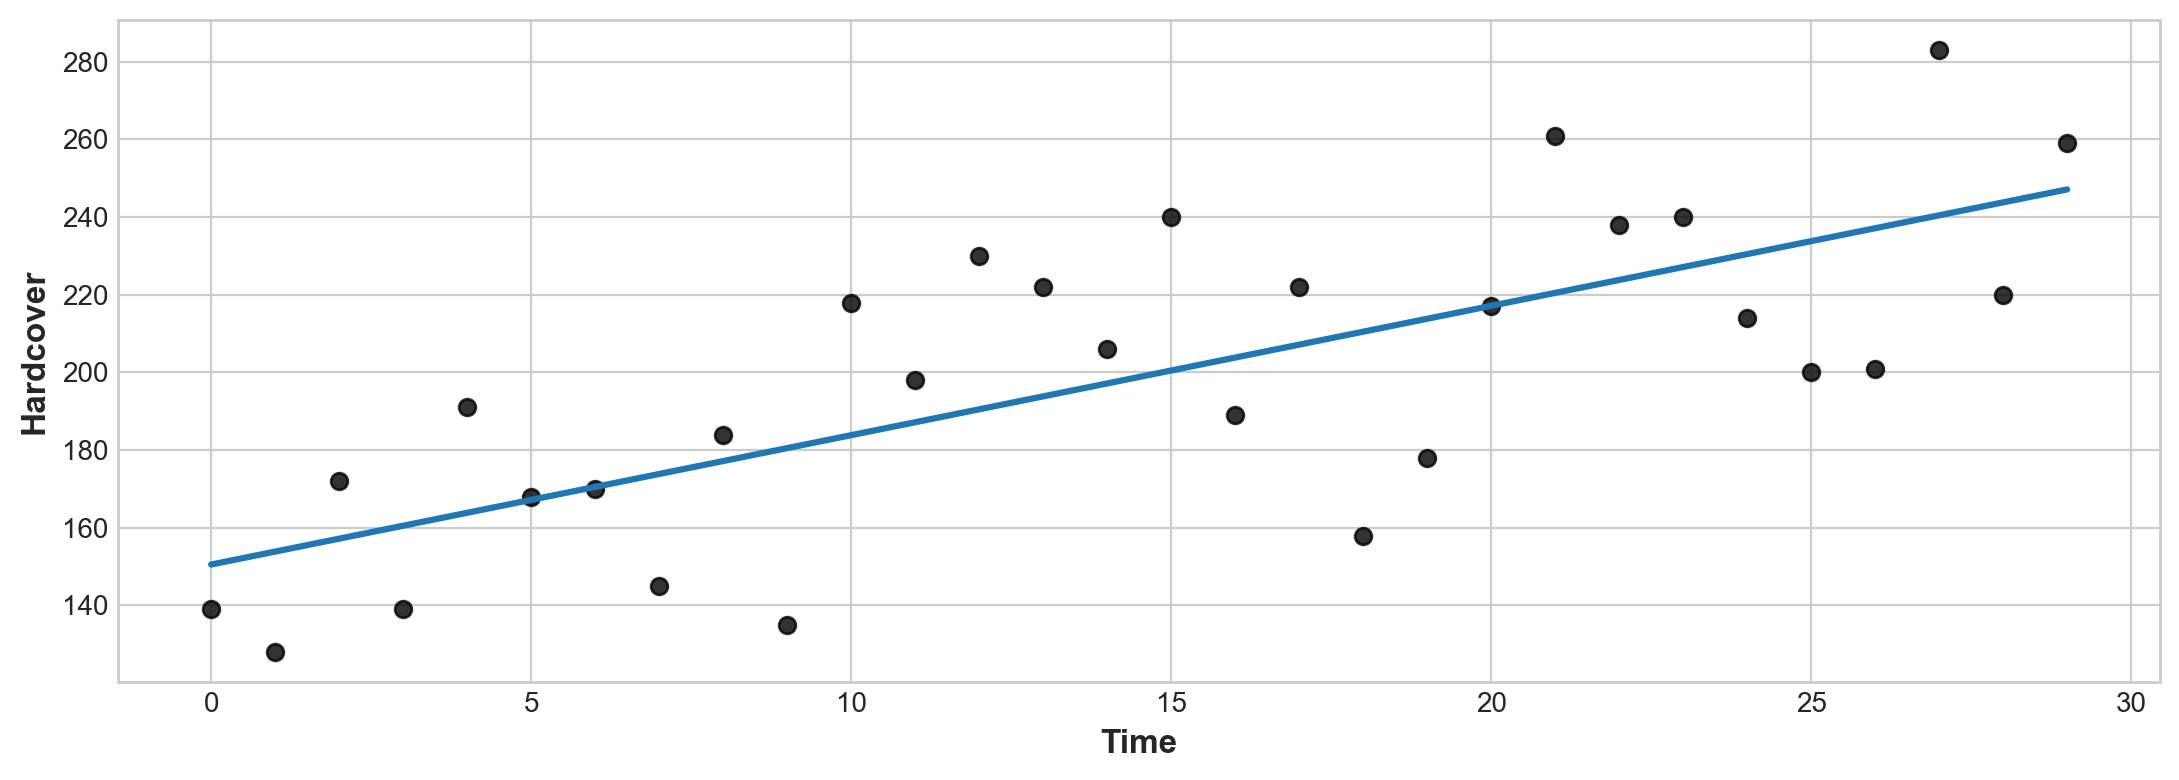

In [9]:
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=1, scatter_kws=dict(color='0.0'))

In [10]:
# ax.set_title('Time Plot of Hardcover Sales')

In [11]:
df['Lag_1'] = df['Hardcover'].shift(3)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

In [12]:
df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,NaN
2000-04-03,172,NaN
2000-04-04,139,139.0
2000-04-05,191,128.0


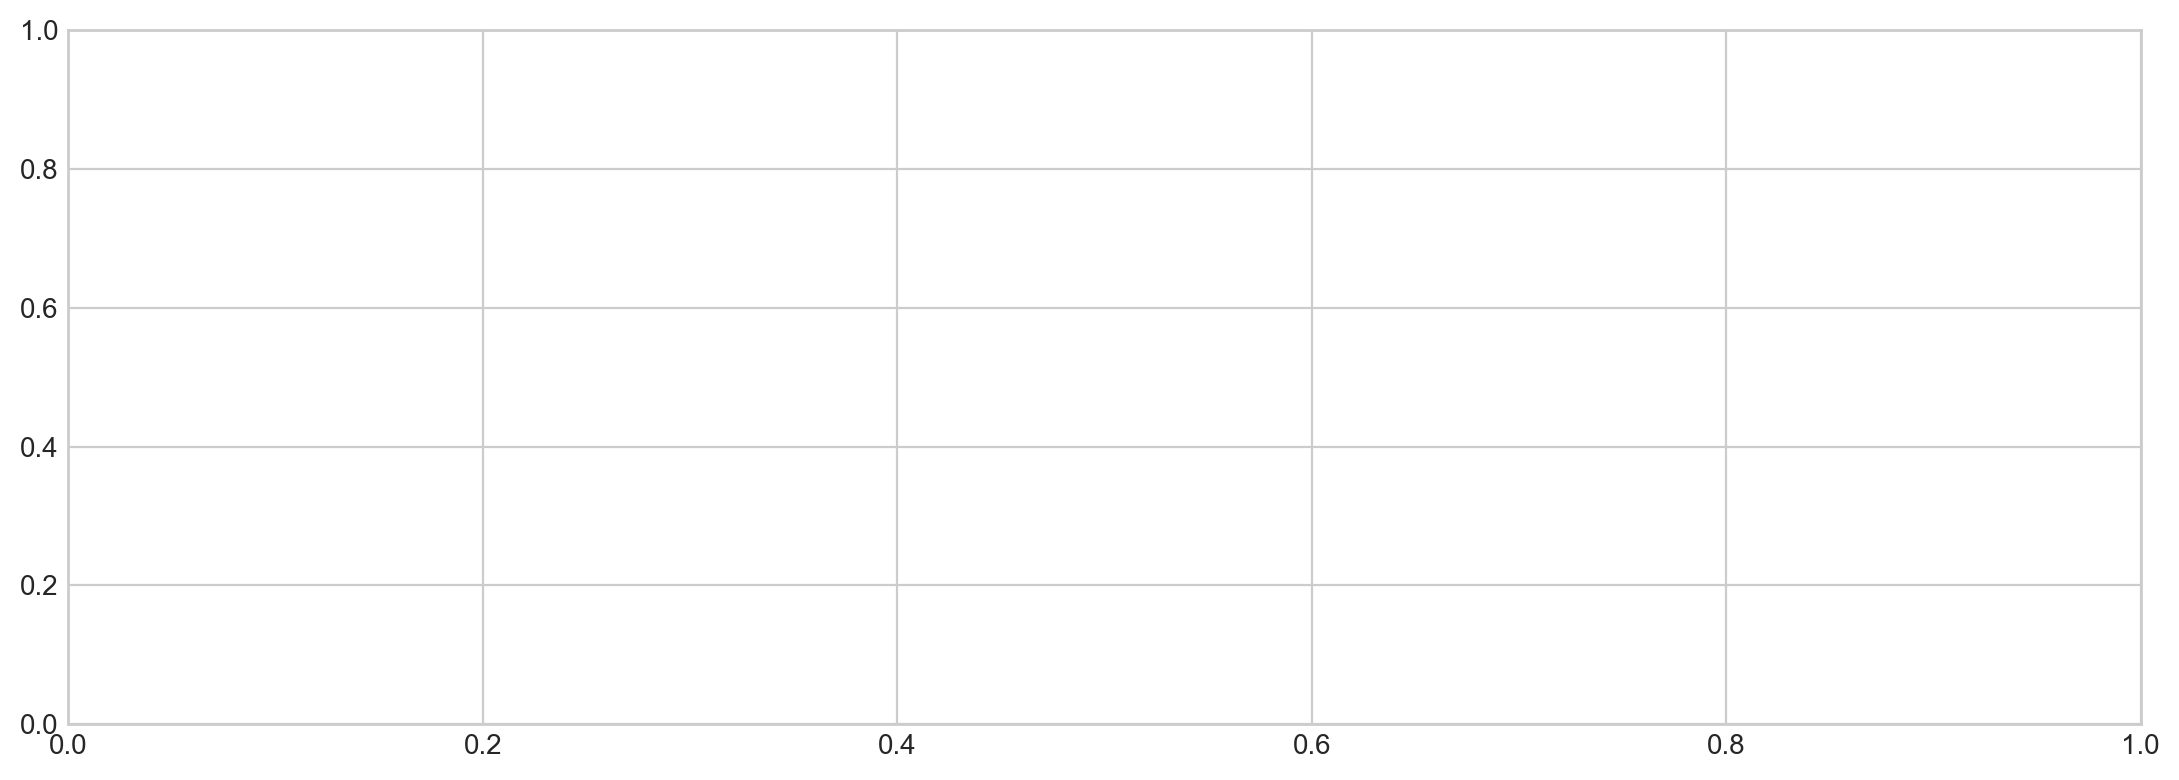

In [13]:
fig, ax = plt.subplots()

Text(0.5, 1.0, 'Lag Plot of Hardcover Sales')

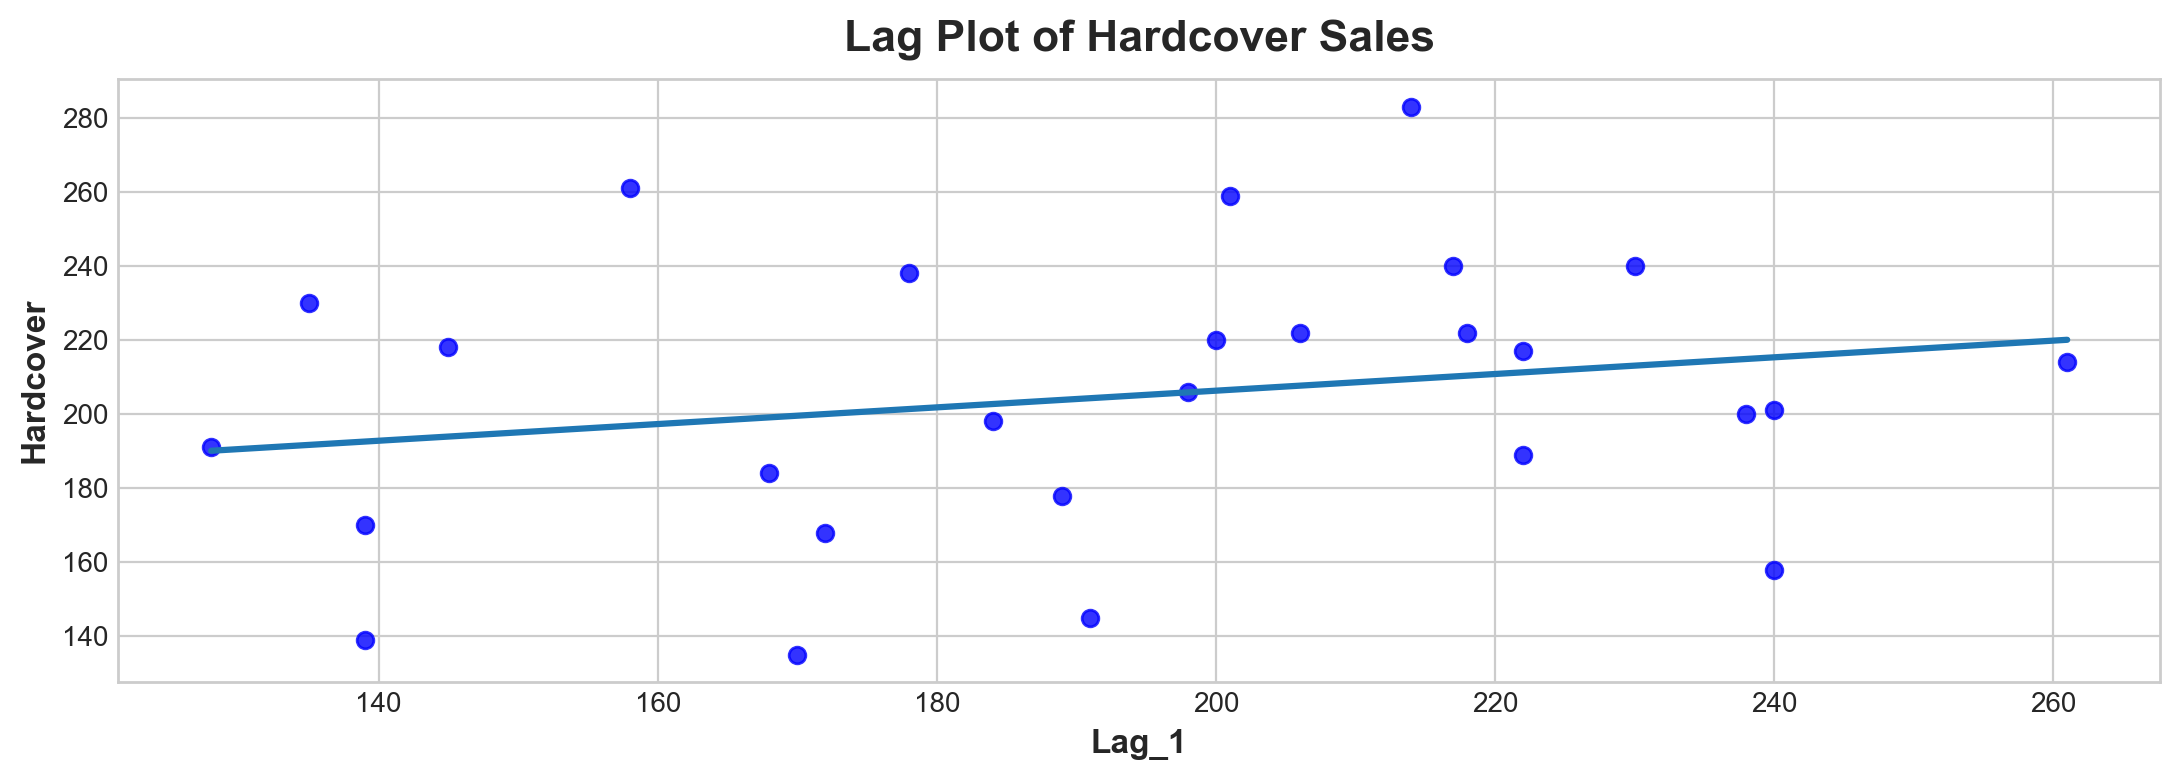

In [14]:
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='b'))
# ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales')

TUNNEL DATA

In [3]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [4]:
tunnel = pd.read_csv('../resources/tunnel.csv', parse_dates=['Day'], index_col='Day')
# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()
from sklearn.linear_model import LinearRegression
tunnel_copy = tunnel.copy()

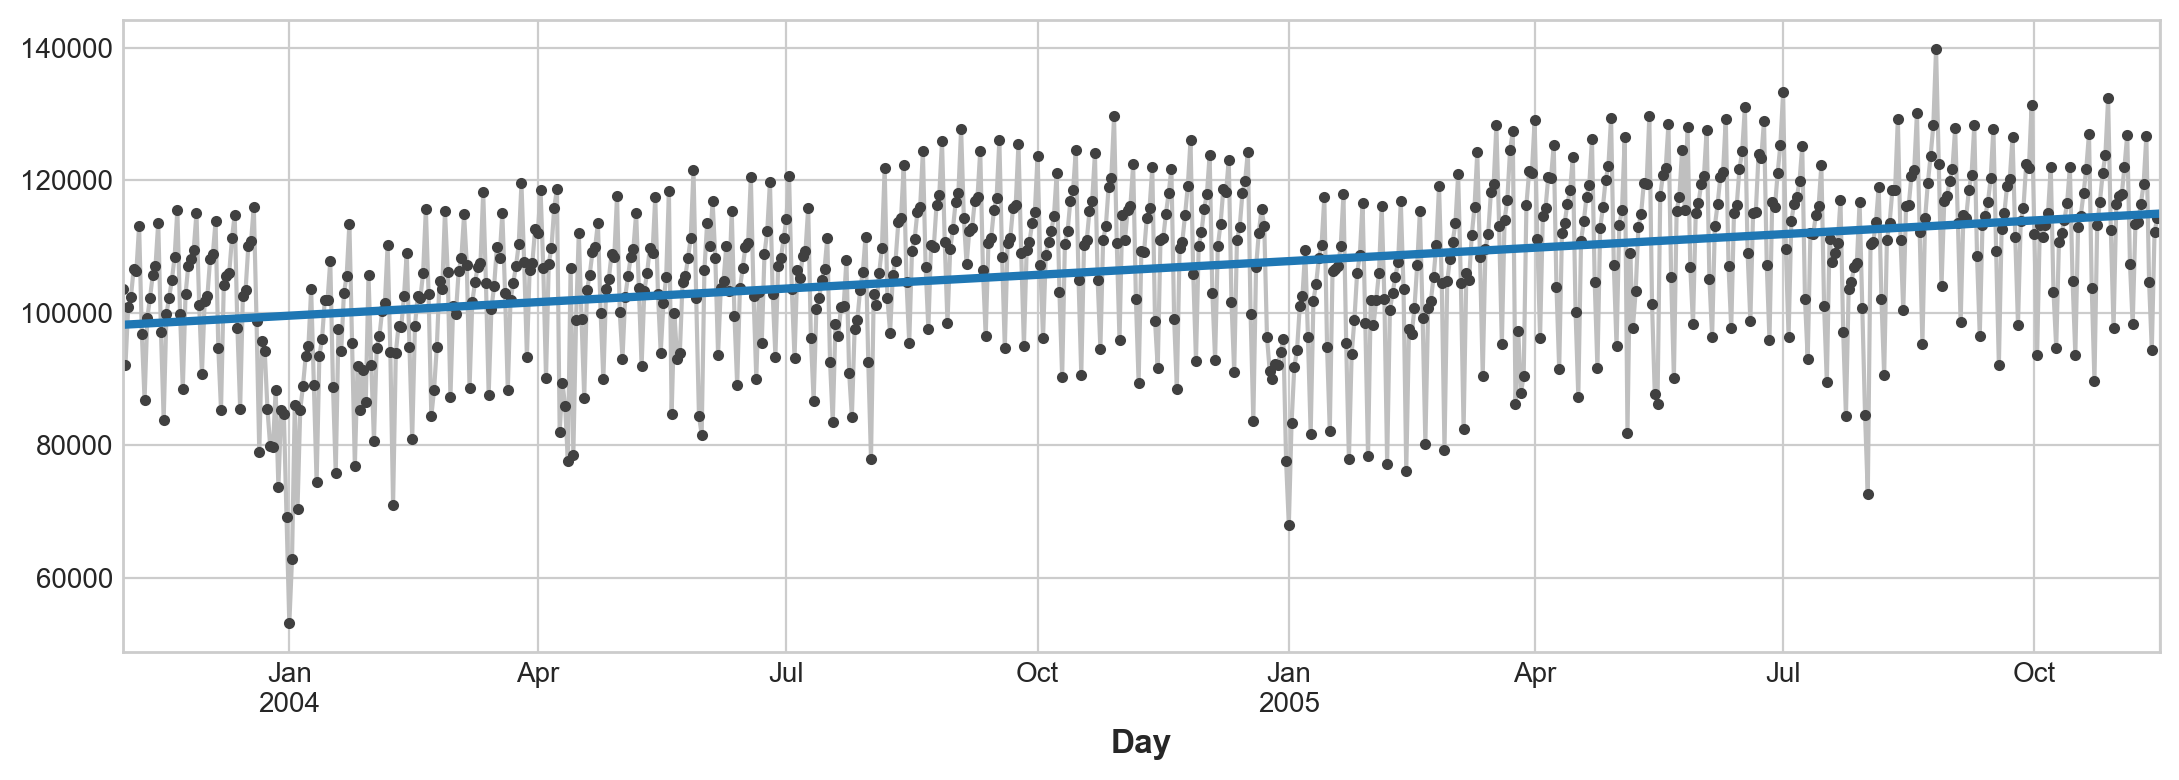

In [15]:

tunnel['Time'] = np.arange(len(tunnel.index))

X = tunnel.loc[:, ['Time']] # time-step feature
y = tunnel.loc[:, ['NumVehicles']] # target
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X)[:,0], index=X.index)


ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)



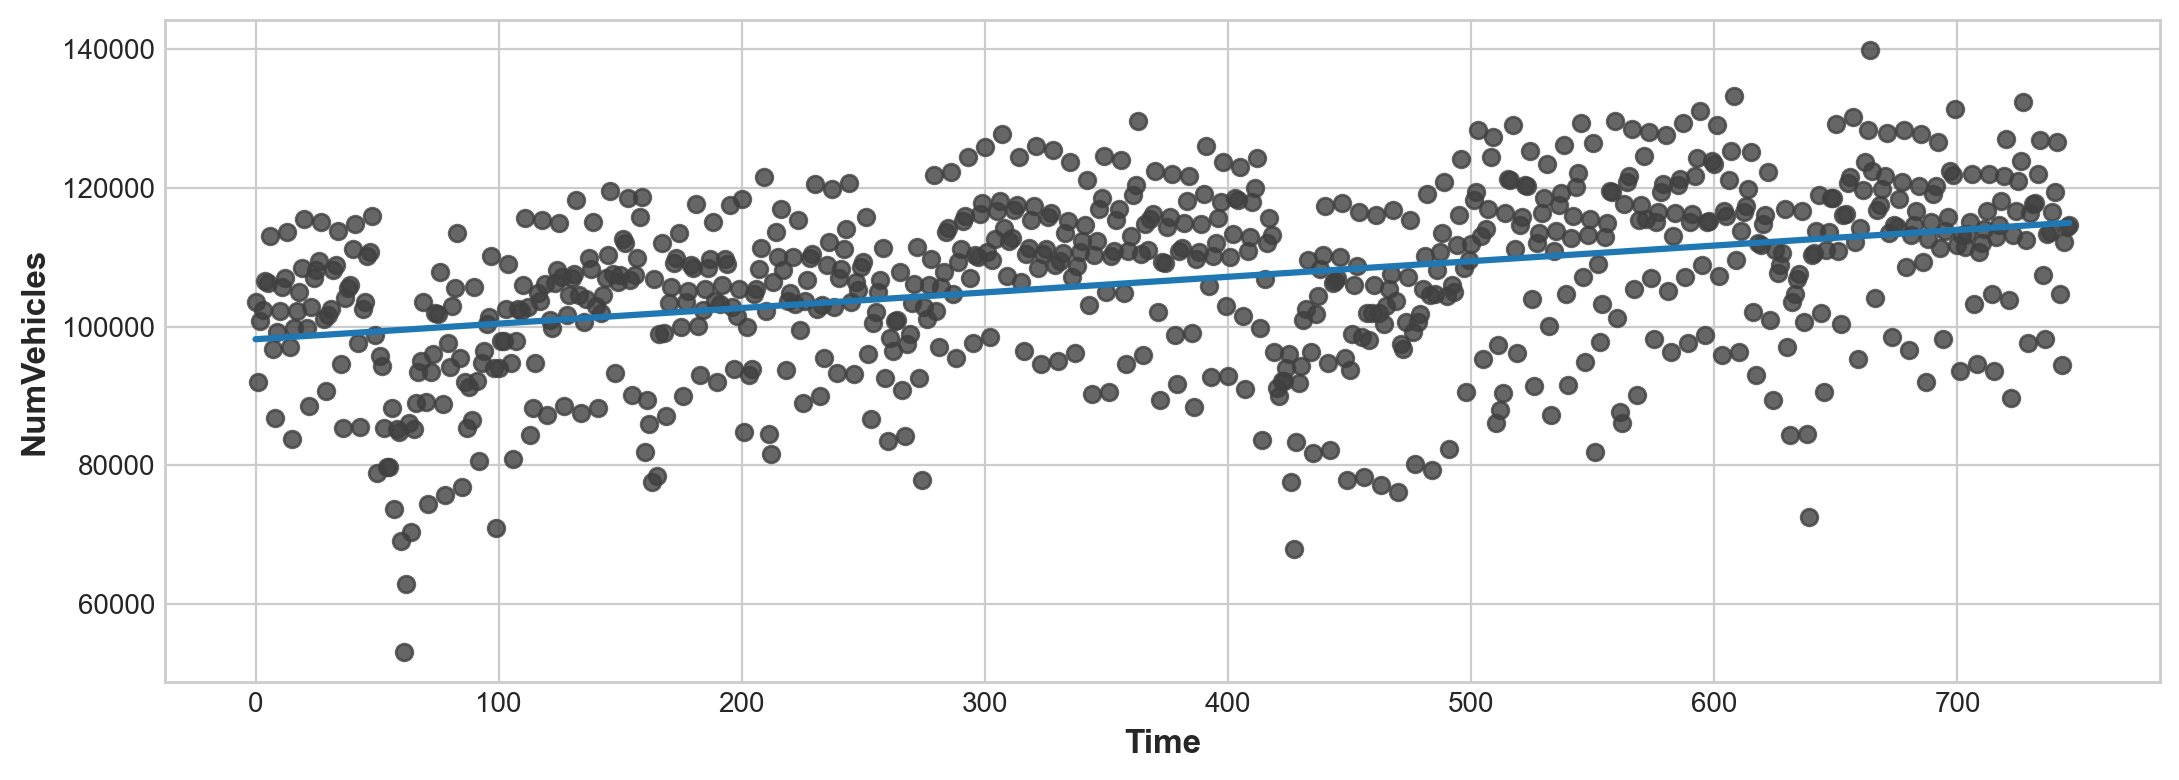

In [79]:
ax = sns.regplot(x='Time', y='NumVehicles', data=tunnel, ci=None, scatter_kws=dict(color='0.25'))

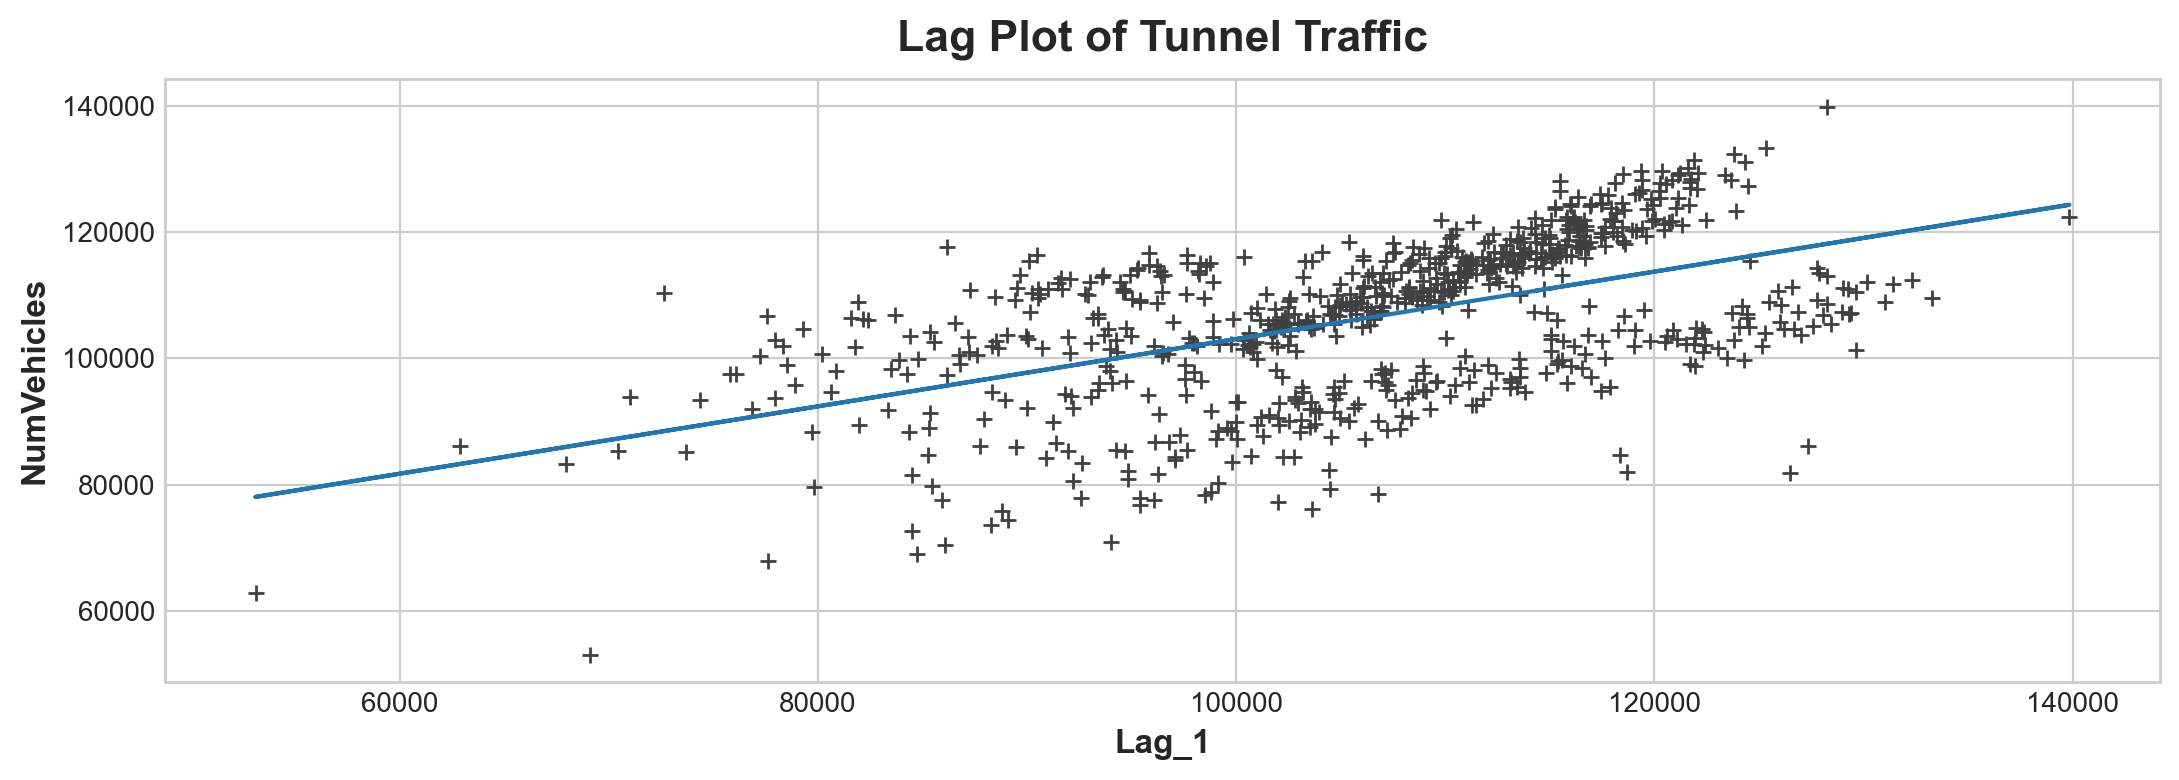

In [13]:
tunnel_copy['Leg_1'] = tunnel_copy['NumVehicles'].shift(1)

new_X = tunnel_copy.loc[:, ['Leg_1']] # lag feature
new_y = tunnel_copy.loc[:, 'NumVehicles'] # target
new_X.dropna(inplace=True)
new_y, new_X = new_y.align(new_X, join='inner')
model = LinearRegression()
model.fit(new_X, new_y)
y_pred = pd.Series(model.predict(new_X), index=new_X.index)




fig, ax = plt.subplots() # creates a figure with only one axes for a single plot
ax.plot(new_X, new_y, '+', color='0.25')
ax.plot(new_X, y_pred)


ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');


# TRENDS

In [47]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
tunnel = pd.read_csv("../resources/tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()
tunnel.tail()

,NumVehicles
Day,
2005-11-12,104646
2005-11-13,94424
2005-11-14,112165
2005-11-15,114296
2005-11-16,114690


<Axes: xlabel='Day'>

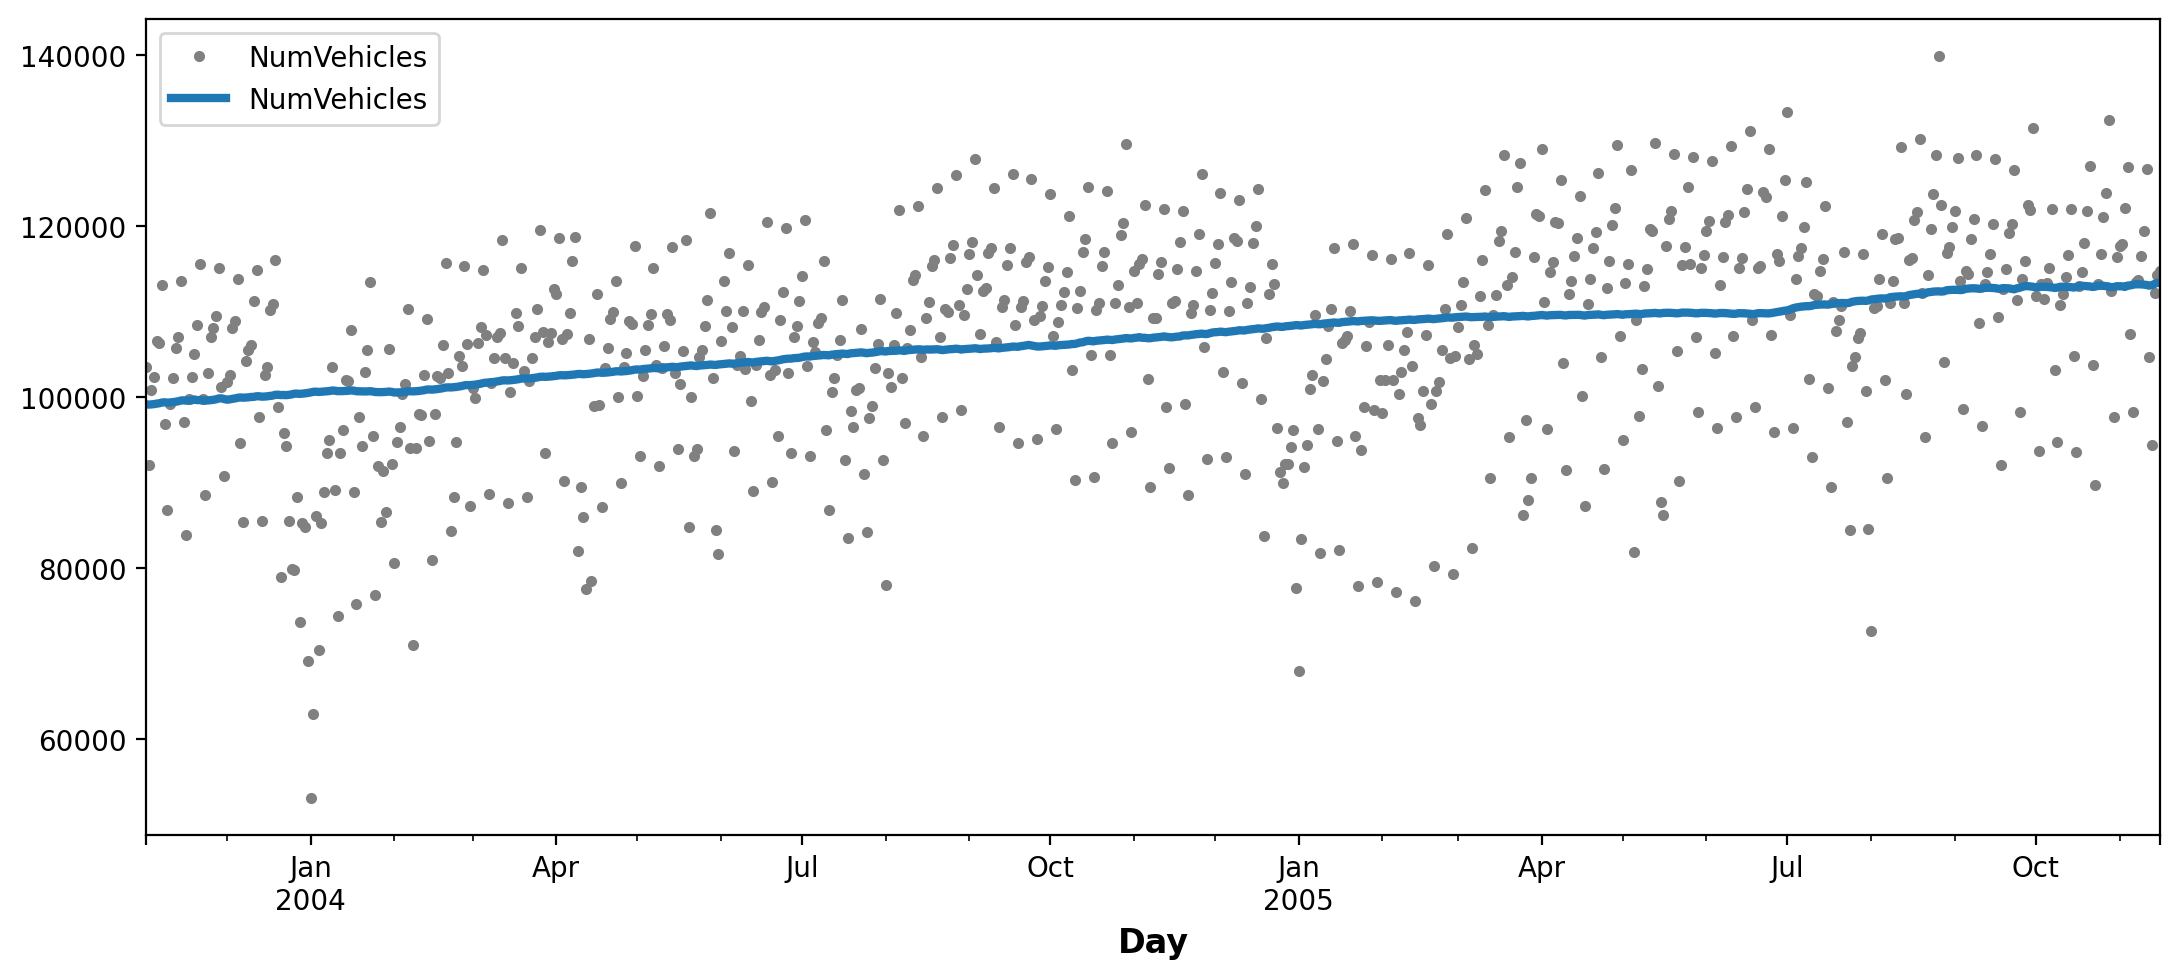

In [30]:
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True, # puts the average at the center of the window
    
    min_periods=183,  # choose about half the window size
).mean()   

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax,
    linewidth=3
)

In [32]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


In [34]:
from sklearn.linear_model import LinearRegression

y = tunnel['NumVehicles']
# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index = X.index)

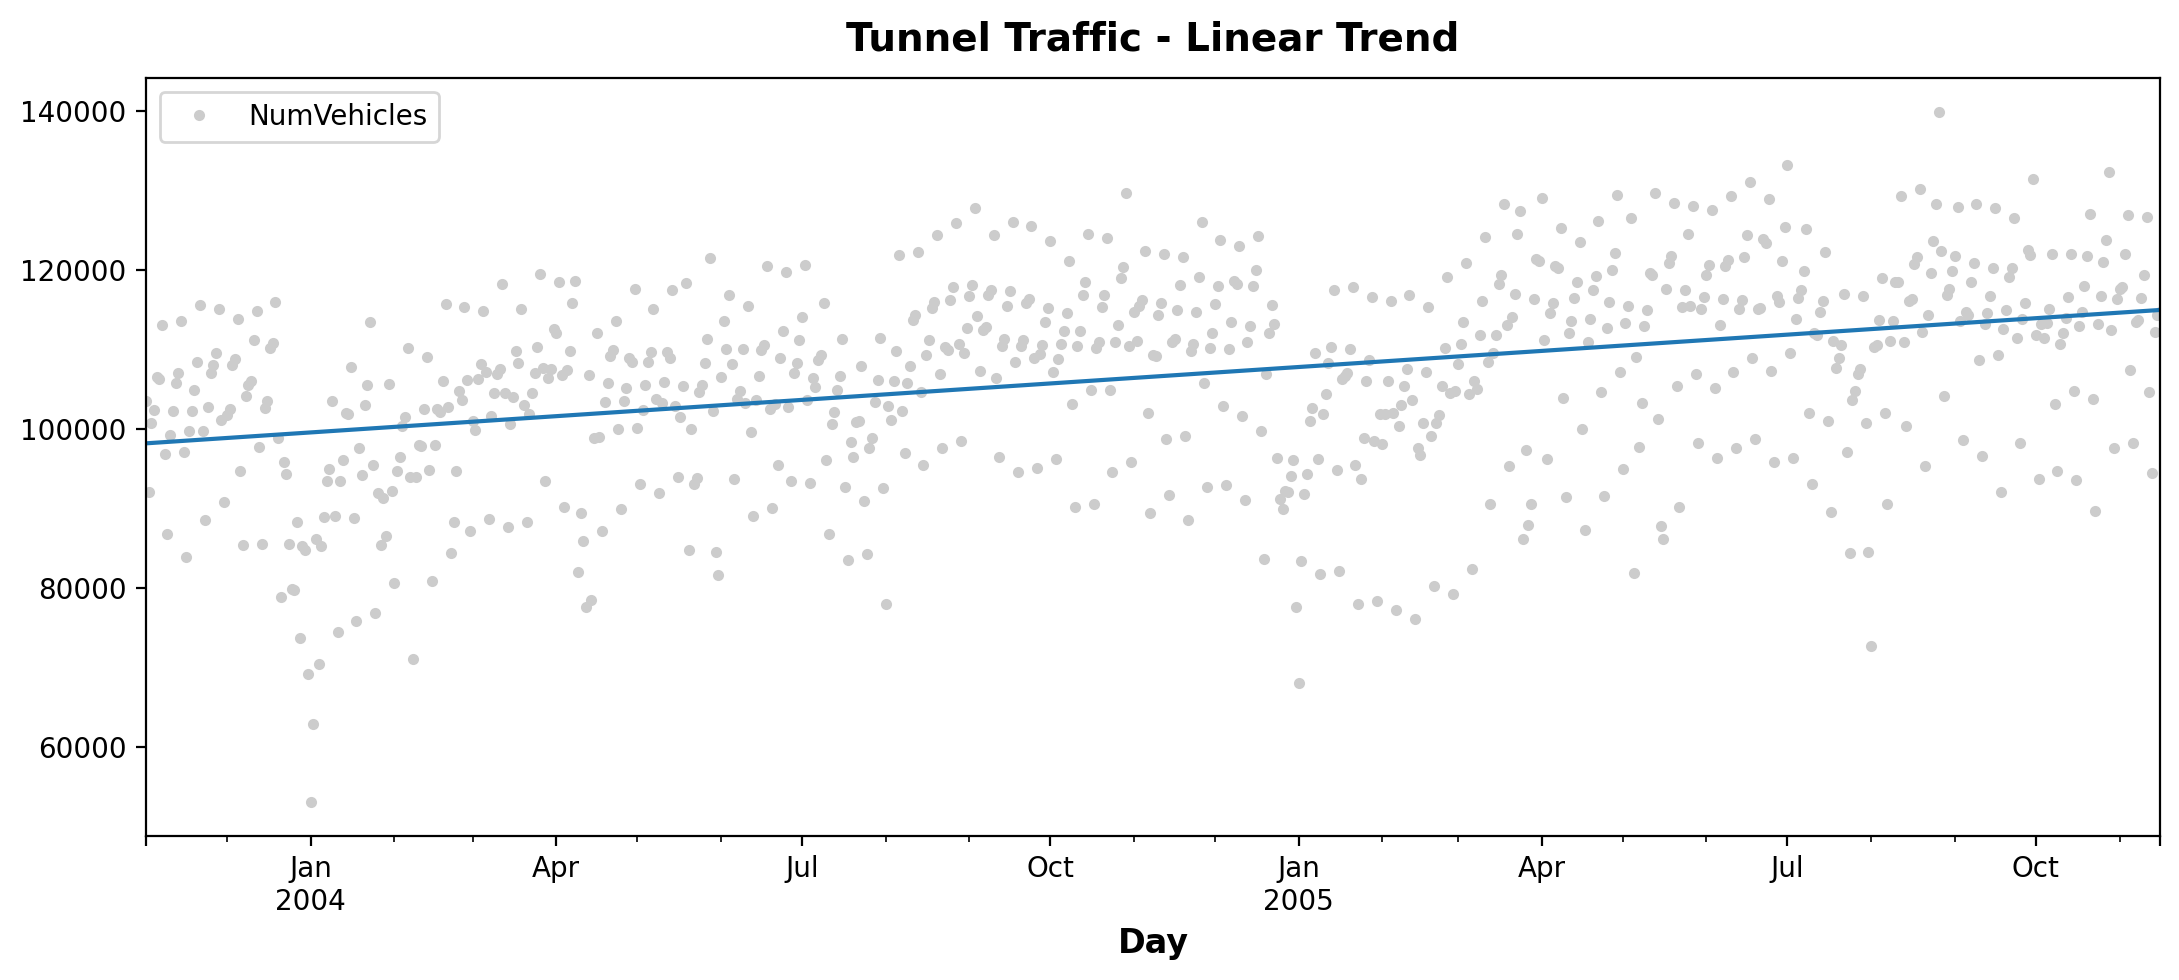

In [41]:
ax = tunnel.plot(style='.', color='0.80', title='Tunnel Traffic - Linear Trend')
ax = y_pred.plot(ax=ax)

The trend discovered by our LinearRegression model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.

To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

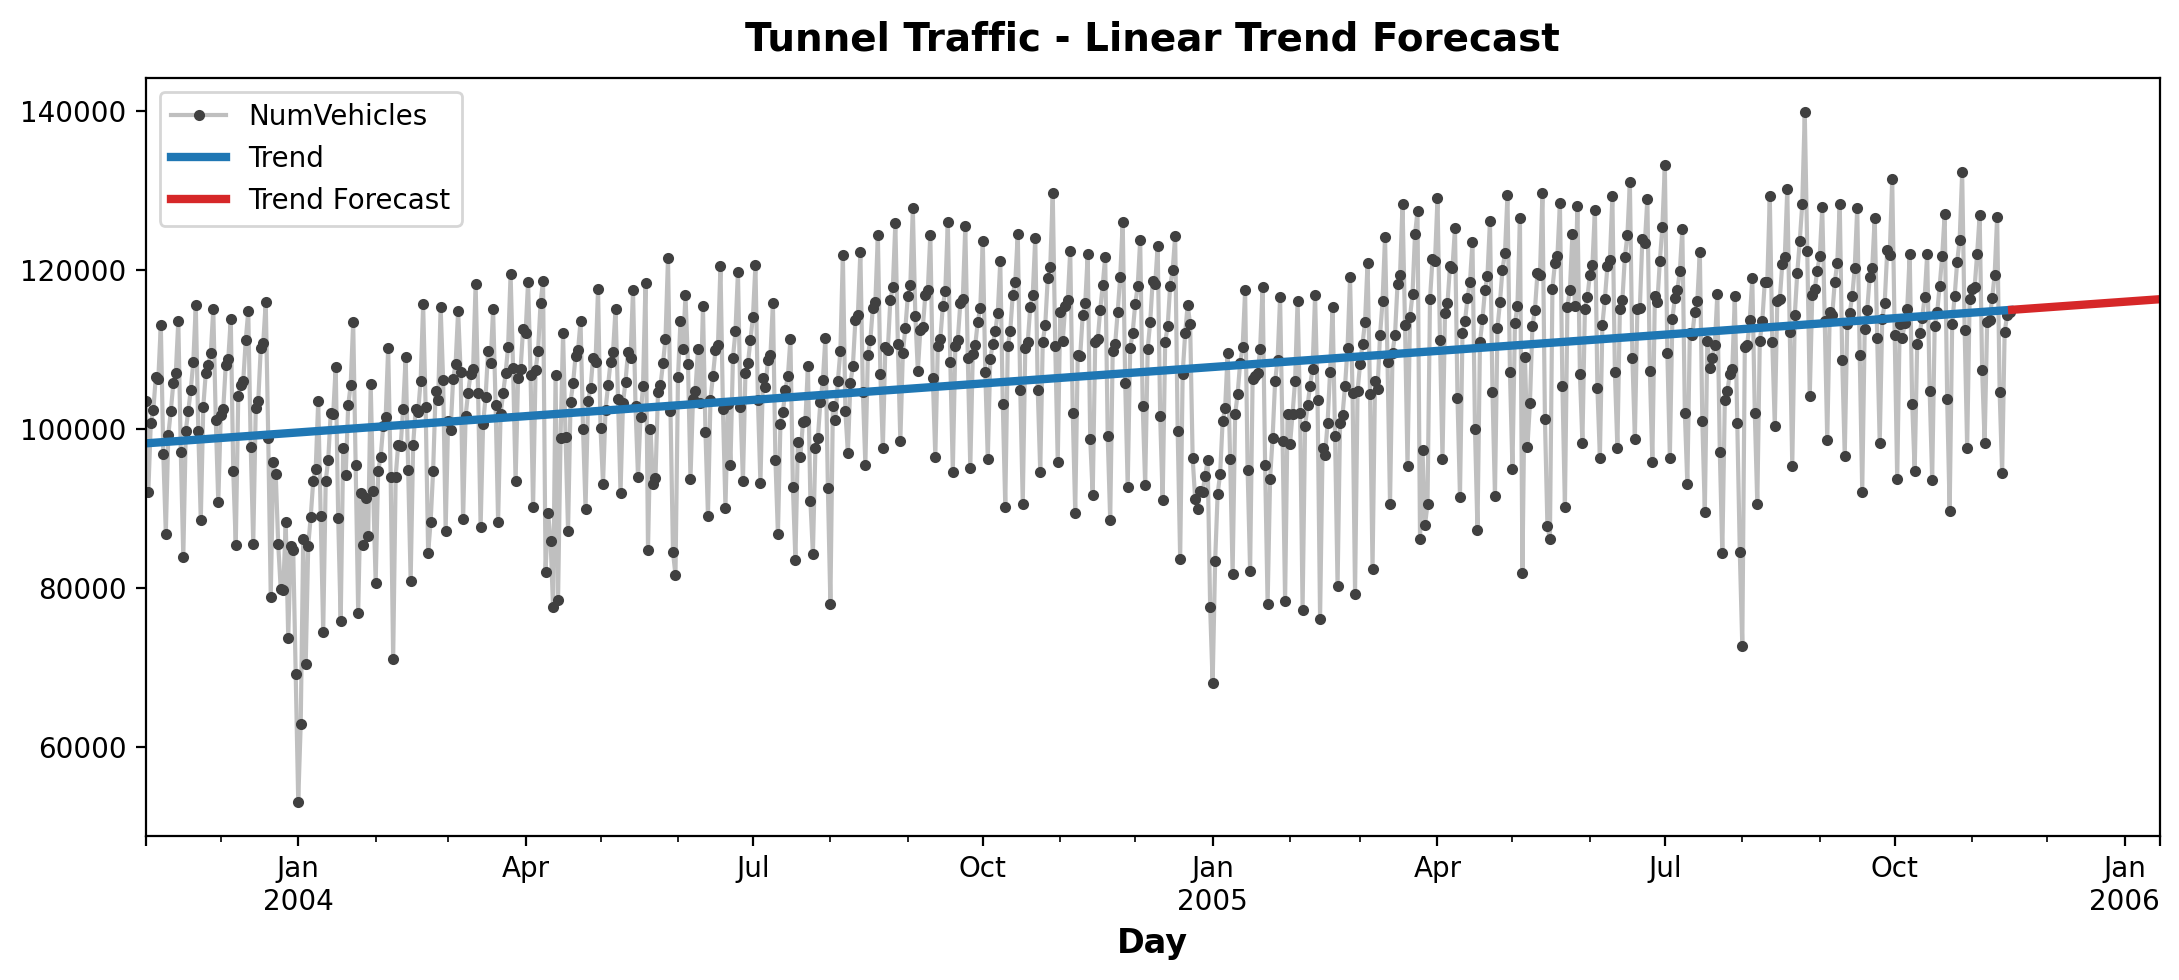

In [53]:
X_fore = dp.out_of_sample(steps=60)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
ax = tunnel.plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
ax.legend()

# Seasonality

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

plt.style.use('seaborn-v0_8')

# Using this rc function we can set some parameters on different components like, figure, lines, font, etc.
#  plt.rc('group name goes here', **kwargs_for_that_group)
plt.rc('figure', autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)


In [46]:
def seasonal_plot(X, y, period, freq, ax=None):
    
    if ax is None:
        _, ax = plt.subplots()
        
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    # ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


tunnel = pd.read_csv("../resources/tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")


In [47]:
X = tunnel.copy()

X['day'] = X.index.dayofweek
X['week'] = X.index.week
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

<Axes: xlabel='dayofyear', ylabel='NumVehicles'>

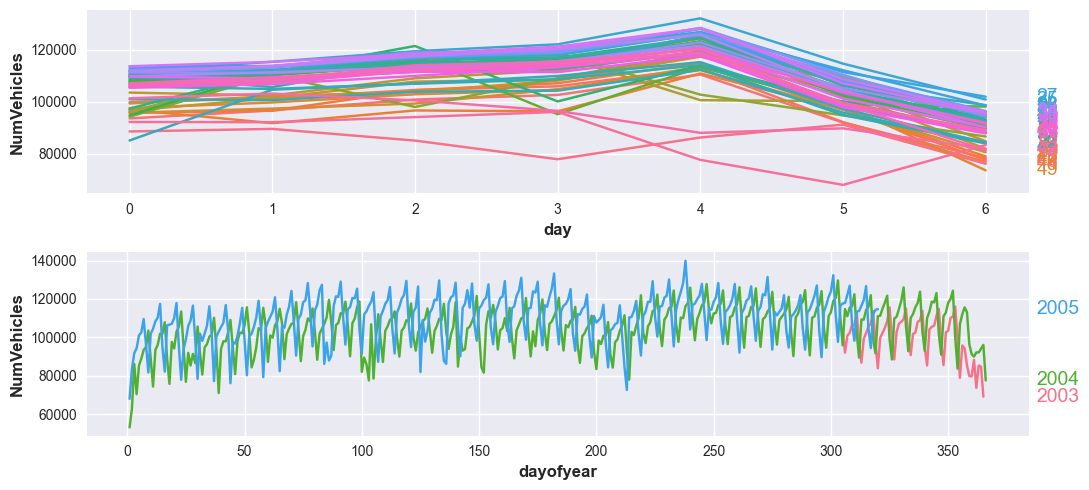

In [48]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
seasonal_plot(X, y='NumVehicles', period='week',  freq='day', ax=ax1)
seasonal_plot(X, y='NumVehicles', period='year',  freq='dayofyear', ax=ax2)


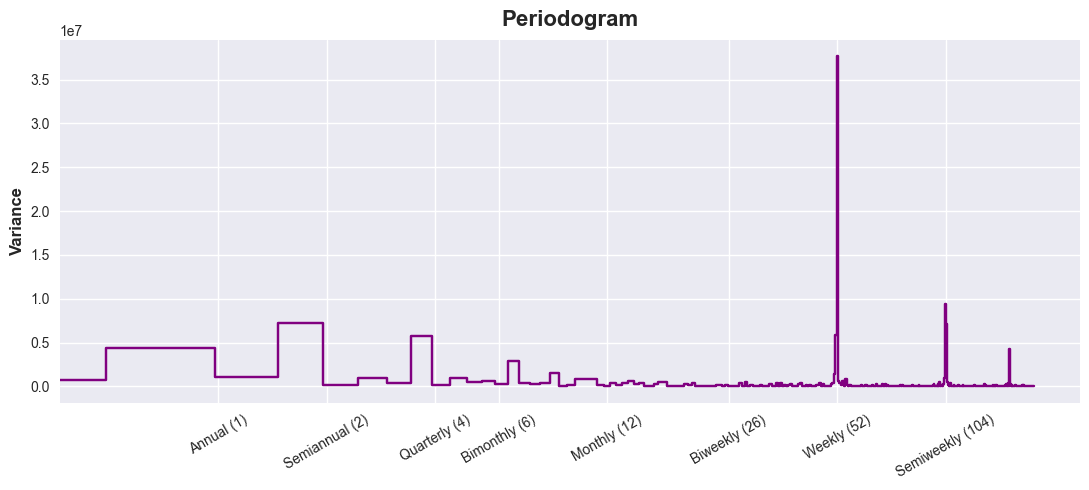

In [49]:
plot_periodogram(tunnel.NumVehicles);



The periodogram agrees with the seasonal plots above: a strong weekly season and a weaker annual season. The weekly season we'll model with indicators and the annual season with Fourier features. From right to left, the periodogram falls off between Bimonthly (6) and Monthly (12), so let's use 10 Fourier pairs.

We'll create our seasonal features using DeterministicProcess, the same utility we used in Lesson 2 to create trend features. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":


In [54]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq='A', order=10)
dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,         # dummy feature for bias (y-intercept)
    order=1,               # trend (order 1 means linear)
    seasonal=True,         # weekly seasonality (indicators)
    additional_terms=[fourier], # annual seasonality (fourier)
    drop=True              # drop terms to avoid collinearity
)

X = dp.in_sample()

With our feature set created, we're ready to fit the model and make predictions. We'll add a 90-day forecast to see how our model extrapolates beyond the training data. The code here is the same as that in earlier lessons.

In [60]:
y = tunnel['NumVehicles']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)


                   
X_fore = dp.out_of_sample(steps=180)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

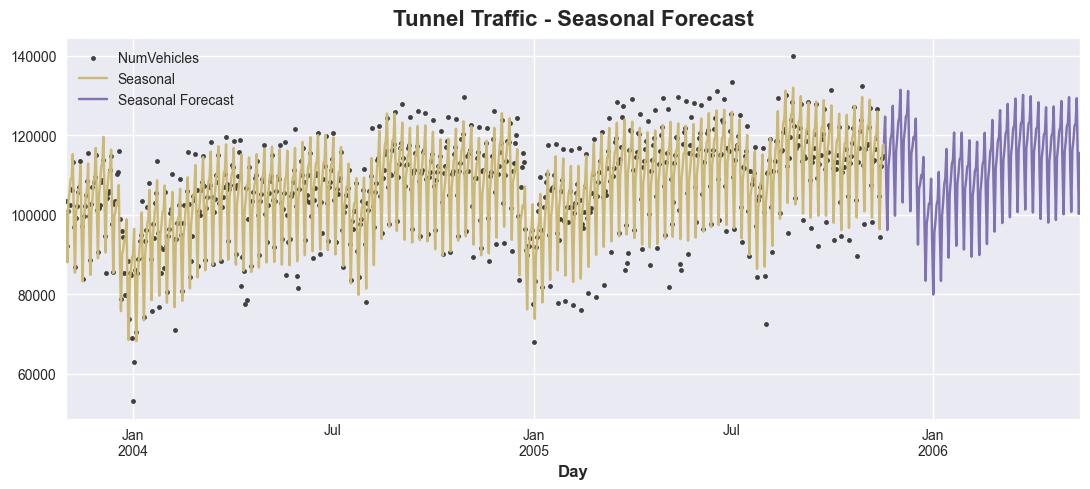

In [61]:
ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal", color='C4')
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()